In [1]:
import matplotlib
matplotlib.rcParams['text.usetex'] = False
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize, stats, integrate
from qutip import *

In [46]:
# h = 6.62607004*10**(-34)
hbar = 1 # NECESSARY TO MAKE SOLVER WORK
h = hbar*2*np.pi

# Unit conversions
# MHz = 10.0**6
# GHz = 10.0**9
# kHz = 10.0**3
# mus = 10.0**-6
# ns = 10.0**-9
MHz = 10.0**(-3)
GHz = 1.0 # NECESSARY TO MAKE SOLVER WORK
kHz = 10.0**(-6)
mus = 10.0**3
ns = 1.0

# number of cavity states
Nr = 3
# number of transmon states
Nj = 4

# cavity/resonator frequency
wr = 2*np.pi*6.92*GHz
# transmon frequency (temporary)
wj = np.asarray([wr]*Nj)
# drive frequency (temporary)
wd = wr

# Transmon constants
EC = 400*MHz*h
EJ = 41.71*EC # temporary

# transmon-resonator coupling strength
g0 = np.pi*347*MHz
gj = g0 * np.asarray([np.sqrt(j+1) for j in range(Nj)])

# cavity dissipation rate
kappa = 2*np.pi*300*kHz
# transmon relaxation rate (2pi/T1)
T1 = 1.7*mus
gamma1 = 2*np.pi/(T1)
# transmon dephasing rate
gammaphi = 0.0
# relative strengths of damping
alphaj = gj/g0
# charge dispersion (from Koch eq. 2.5)
epj = [((-1)**m * EC * 2**(4*m+5)/(np.math.factorial(m)) * \
        np.sqrt(2/np.pi) * (EJ/(2*EC))**(m/2+3/4) * \
        np.exp(-np.sqrt(8*EJ/EC))) \
       for m in range(Nj)]
betaj = 2*epj/(epj[1]-epj[0]) 

# for the TLS stuff
T1p = 2/(gamma1+kappa)
T2p = 4/(gamma1+2*gammaphi+kappa)

use_rwa = True

a = tensor(destroy(Nr), qeye(Nj)) # cavity op

In [47]:
def comm(a, b):
    return(a*b - b*a)

In [48]:
# Transmon corrected energies from perturbation theory (Koch p. 19)
def getWij(i, j, EC, EJ):
    b = destroy(Nj) # pure SHO operators
    Hsho = np.sqrt(8*EC*EJ)*(b.dag()*b + 1/2)-EJ
    evals, ekets = Hsho.eigenstates()
    ECorrect = [evals[j] - EC/12*(6*j**2 + 6*j + 3) for j in range(Nj)]
    return (ECorrect[j]-ECorrect[i])/hbar

# Transmon states from perturbation theory (Koch p. 19)
def getJKets(EC, EJ):
    b = destroy(Nj) # pure SHO operators
    Hsho = np.sqrt(8*EC*EJ)*(b.dag()*b + 1/2)-EJ
    evals, ekets = Hsho.eigenstates()
#     print(evals/hbar)
    ECorrect = [evals[j] - EC/12*(6*j**2 + 6*j + 3) for j in range(Nj)]
#     print("%.3e" % (ECorrect[0]/hbar))
#     print("%.3e" % ((ECorrect[2]-ECorrect[1]-(ECorrect[1]-ECorrect[0]))/hbar))
    jketsCorrect = np.copy(ekets)
    jkets1 = np.asarray([0*basis(Nj,0)]*Nj, dtype=object)
    for j in range(Nj):
        for i in range(Nj):
            if i == j: continue
            quartic = (b+b.dag())**4
            element = quartic.matrix_element(ekets[i], ekets[j])
            jkets1[j] += (element*ekets[i])/(ECorrect[i]-ECorrect[j])
        jkets1[j] *= -EC/12
    jketsCorrect += jkets1
    
    return jketsCorrect

In [49]:
# also known as the nkets
def getPhotonKets():
    a = destroy(Nr)
    H = hbar*wr*a.dag()*a
    # need to include the drive term here??
    evals, ekets = H.eigenstates()
    return ekets

In [50]:
# JC with coherent drive (Bishop p. 1)

def getHjc(xi, wd, jkets, pN):
    Hjc_0 = hbar*wr*(a.dag()*a+1/2)
    for j in range(Nj):
        Hjc_0 += hbar*wj[j]*tensor(qeye(Nr), ket2dm(jkets[j]))
    for j in range(Nj-1):
        temp = a*tensor(qeye(Nr), jkets[j+1]*jkets[j].dag())
        Hjc_0 += hbar*gj[j]*(temp + temp.dag())
#     Hjc_0 = pN*Hjc_0
    
    # Break up Hjc into time independent, dependent to put into mesolve
    # (See http://qutip.org/docs/latest/guide/dynamics/dynamics-time.html)
    Hjc_1 = hbar*xi*a.dag()
#     Hjc_1 = pN*Hjc_1
    Hjc_2 = hbar*xi*a
#     Hjc_2 = pN*Hjc_2
    def Hjc1_time_dep(t, args):
        return np.exp(-1j*wd*t)
    def Hjc2_time_dep(t, args):
        return np.exp(1j*wd*t)
    
    Hjc = [Hjc_0, [Hjc_1, Hjc1_time_dep], [Hjc_2, Hjc2_time_dep]]
    # Hjc = Hjc_0
    # print(Hjc_0)
    return Hjc

# projection operator onto total n+j = N excitations
def projN(N, nkets, jkets):
    pN = 0*tensor(qeye(Nr), qeye(Nj))
    for n in range(Nr):
        for j in range(Nj):
            if n+j > N: continue
#             print(n,j)
            njKet = tensor(nkets[n], jkets[j])
            pN += ket2dm(njKet)
    return pN

In [51]:
def intensityTLS(xi, wd, EC, EJ):
    Omega = np.sqrt(2)*xi
    Delta = getWij(0, 1, EC, EJ)-g0-wd
    numerator = T2p*Omega*np.sqrt((Delta**2*T2p**2 + 1)/2)
    denominator = Delta**2*T2p**2 + T1p*T2p*Omega**2 + 1
    return (numerator/denominator)**2/4 # A^2/A1^2

def rhoSteady(xi, wd, EC, EJ):
    Omega = np.sqrt(2)*xi
    Delta = getWij(0, 1, EC, EJ)-g0-wd
    x = -(Delta*T2p**2*Omega)/(1+Delta**2*T2p**2 + T1p*T2p*Omega**2)
    y = (T2p*Omega)/(1 + Delta**2*T2p**2 + T1p*T2p*Omega**2)
    z = -(1 + Delta**2*T2p**2)/(1 + Delta**2*T2p**2 + T1p*T2p*Omega**2)
    nkets = getPhotonKets()
    jkets = getJKets(EC, EJ)
    down = tensor(nkets[0], jkets[0])
    up = (tensor(nkets[0], jkets[0]) - tensor(nkets[0], jkets[1]))/np.sqrt(2)
    Sigmax = up*down.dag() + down*up.dag()
    Sigmay = -1j*(up*down.dag() - down*up.dag())
    Sigmaz = up*up.dag() - down*down.dag()
    rho = (tensor(qeye(Nr), qeye(Nj)) + x*Sigmax + y*Sigmay + z*Sigmaz)/2
    return rho

In [52]:
nPoints = 100
xData = np.linspace(6.5*GHz, 7.1*GHz, num = nPoints)
yData = []

# drive strength: expect supersplitting when strength>1
strength = 0.1
xi = (1/np.sqrt(2*T1p*T2p))*strength
# print(xi)


# Find the EJ that gets you closest to the one in the paper
EJtry = np.linspace(41*EC, 42*EC, num = 50)
bestEJ = 0
minDist = 1000*GHz
closestFreq = 0
for EJ in EJtry:
    yData = []
    for fd in xData:
        yData.append(intensityTLS(xi, fd*2*np.pi, EC, EJ))
    peakI = np.max(yData)
    peakFreqLoc = np.where(yData == peakI)[0][0]
    peakFreq = xData[peakFreqLoc]
    if np.abs(peakFreq - 6.734*GHz) < minDist:
        bestEJ = EJ
        closestFreq = peakFreq
        minDist = np.abs(peakFreq - 6.734*GHz)
print(bestEJ/EC)
print(closestFreq/GHz)

41.714285714285715
6.736363636363636


Done with strength=0.8


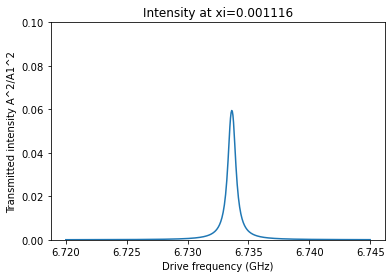

Done with strength=1.7


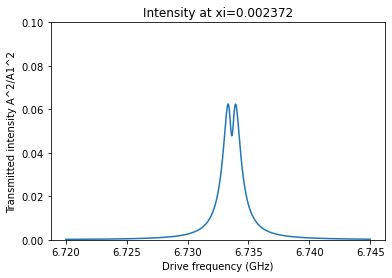

Done with strength=5.0


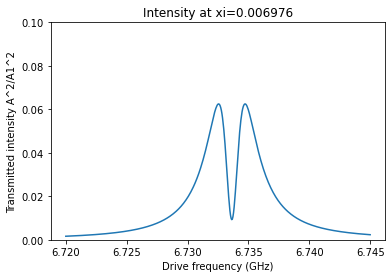

Done with strength=20.0


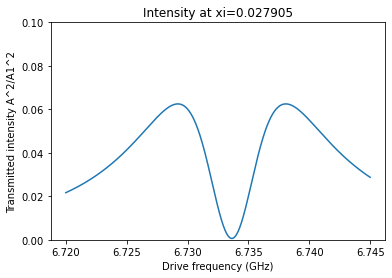

In [16]:
nPoints = 500
xData = np.linspace(6.72*GHz, 6.745*GHz, num = nPoints)

# drive strength: expect supersplitting when strength>1
for strength in [0.8, 1.7, 5, 20]:
    xi = (1/np.sqrt(2*T1p*T2p))*strength
    fig2TLSYData = []
    for i, fd in enumerate(xData):
#         if i % 100 == 0:
#             print("%d of %d done" % (i, nPoints))
        fig2TLSYData.append(intensityTLS(xi, fd*2*np.pi, EC, bestEJ))
    print("Done with strength=%.1f" % strength)
    
    plt.plot(xData, fig2TLSYData)
    plt.xlabel('Drive frequency (GHz)')
    plt.ylabel('Transmitted intensity A^2/A1^2')
    plt.ylim(0, 0.1)
    plt.title("Intensity at xi=%f" % xi)
    plt.show()

In [56]:
# charge dispersion (from Koch eq. 2.5)
def betaj(EC, EJ):
    epj = [((-1)**m * EC * 2**(4*m+5)/(np.math.factorial(m)) * \
        np.sqrt(2/np.pi) * (EJ/(2*EC))**(m/2+3/4) * \
        np.exp(-np.sqrt(8*EJ/EC))) \
       for m in range(Nj)]
    return 2*epj/(epj[1]-epj[0])

# Get the steady state intensity
def intensity(xi, wd, EC, EJ):
    jkets = getJKets(EC, EJ)
    nkets = getPhotonKets()
    # truncate to N = 7 Hilbert space
#     pN = projN(3, nkets, jkets)
    # print(pN)
    pN = tensor(qeye(Nr), qeye(Nj))
    
    # Damping terms
    c_ops = []
    c_ops.append(kappa*lindblad_dissipator(a))
    
    temp = 0*tensor(qeye(Nr), qeye(Nj))
    for j in range(Nj-1):
        temp += alphaj[j]*jkets[j].dag()*jkets[j+1]
    c_ops.append(gamma1*lindblad_dissipator(temp))
    
    temp = 0*tensor(qeye(Nr), qeye(Nj))
    for j in range(Nj-1):
        temp += betaj(EC, EJ)[j]*jkets[j].dag()*jkets[j]
    c_ops.append(gammaphi/2*lindblad_dissipator(temp))
    
#     gnd = tensor(basis(Nr,1), basis(Nj,0)) # |1,g>
    # print(gnd)
#     rho0 = ket2dm(gnd)
    rho0 = rhoSteady(xi, wd, EC, EJ)
    
    maxT = 0.01*T1 # ideally this would be longer but it's taking too long to run
    times = np.linspace(0, maxT, num=int(maxT))
    
    Hjc = getHjc(xi, wd, jkets, pN)

    # output = mesolve(Hjc, rho0, times, c_ops, [a], options=Options(nsteps=100000))
    # rho_t = output.states # rho(t)
    # print(rho_t)
    
    # output = mesolve(Hjc, rho0, times, c_ops, [a], options=Options(nsteps=1000), progress_bar=True)
    output = mesolve(Hjc, rho0, times, c_ops, [a])
    expect_a = output.expect[0]
    # print(expect_a)
    
    # Bishop Eq. 2 (steady state transmission amp)
    intensity_t = np.abs(expect_a)**2 # A^2/A1^2
    # print(intensity_t)
    result = np.average(intensity_t[int(maxT)-10:])
    return result

# print(intensity(xi, wd, EC, EJ))

In [57]:

# this needs to be like 500 or sthg, but this already takes forever
nPoints = 20
xData = np.linspace(6.88*GHz, 7.00*GHz, num = nPoints)
yData = []

# drive strength (temporary)
xi = wd/4000
for i, fd in enumerate(xData):
    yData.append(intensity(xi, fd*2*np.pi, EJ, EC))
    print("%d of %d done" % (i+1, nPoints))

1 of 20 done
2 of 20 done
3 of 20 done
4 of 20 done
5 of 20 done
6 of 20 done
7 of 20 done
8 of 20 done
9 of 20 done
10 of 20 done
11 of 20 done
12 of 20 done
13 of 20 done
14 of 20 done
15 of 20 done
16 of 20 done
17 of 20 done
18 of 20 done
19 of 20 done
20 of 20 done


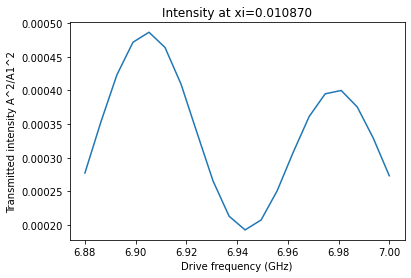

In [58]:
plt.plot(xData, yData)
plt.xlabel('Drive frequency (GHz)')
plt.ylabel('Transmitted intensity A^2/A1^2')
plt.title("Intensity at xi=%f" % xi)
plt.show()

# Lol idk why this plot is so weird, maybe just need more points